In [1]:
import glob, serial, time, math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import iradon
from IPython.display import display
import random

In [727]:
ports = glob.glob('/dev/tty[A-Za-z]*') # Modify if on a platform other than Linux
ports[0]

'/dev/ttyACM0'

In [728]:
ser = serial.Serial(ports[0], 115200)

In [729]:
ser.read_all()

b''

In [730]:


ds = {0:b'i',
     7:b'j',
     3:b'k',
     4:b'l',
     2:b'm',
     5:b'n',
     6:b'o',
     1:b'p'}

es = {0:b'a',
     7:b'b',
     1:b'c',
     6:b'd',
     2:b'e',
     4:b'f',
     3:b'g',
     5:b'h'}

def read_d(d):
    ser.write(ds[d])
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def set_l(l):
    ser.write(es[l])
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def loff():
    ser.write(b'A')
    while ser.in_waiting < 1:
        pass # wait for a response
    return ser.read_all()

def read_all():
    a = []
    # Take a base set of readings
    loff()
    for d in range(8):
        a.append(int(read_d(d).strip()))
    for l in range(8):
        loff()
        set_l(l)
        for d in range(8):
            a.append(int(read_d(d).strip()))
        loff()
    return a

In [639]:
xs = []
ys = []
pos = []
readings = []

for i in range(500):
    x = random.random()*2 - 1
    y = random.random()*2 - 1
    while ((x-2.5)**2 + (y-2.5)**2)>2.5: # Check within safe radius
        x = random.random()*5
        y = random.random()*5
        
    xs.append(x)
    ys.append(y)
    pos.append([x, y])


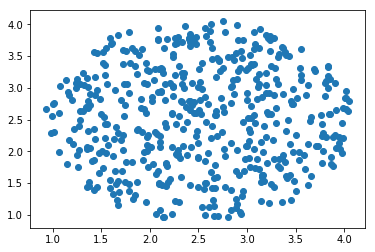

In [640]:
plt.scatter(xs, ys)
plt.show()

In [641]:
f = open('move.gcode', 'w')
f.write("G21\n") #        ;metric values
f.write("G90\n") #       ;absolute positioning


for p in pos:
    f.write('G1 Z5\n')
    f.write('G1 X'+str(p[0]*10))
    f.write(' Y'+str(p[1]*10)+'\n')
    f.write('G1 Z0\n')
    f.write('M0\n') # Pause print and wait for user
    
f.close()

In [ ]:
readings = []

In [1263]:
readings.append(read_all())
print(len(readings))

500


In [1264]:
# len(readings)
print(xs[len(readings)-2], ys[len(readings)-2])
print(xs[len(readings)-1], ys[len(readings)-1])

1.009703253468242 2.3019441309203437
2.7772532830719223 3.8770078922907696


In [1265]:
posinf8_50 = pd.DataFrame(readings)

In [1266]:
posinf8_50['X'] = xs[:500]
posinf8_50['Y'] = ys[:500]
posinf8_50.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,X,Y
0,751,713,728,731,738,750,749,751,735,730,...,733,726,709,738,749,750,745,739,1.537372,2.424437
1,730,714,734,741,745,747,748,752,731,725,...,735,720,726,500,742,735,746,754,3.247863,1.492602
2,741,732,743,745,743,737,740,739,741,738,...,748,723,725,730,746,744,740,740,1.990095,3.258206
3,735,723,750,751,745,750,738,756,733,730,...,743,730,716,500,744,735,739,744,2.287863,3.805902
4,724,743,734,725,745,731,743,743,737,732,...,742,731,737,516,751,742,731,738,3.016146,2.346812


In [1267]:
posinf8_50.to_csv('posinf8_500_readings.csv', index=False)

# Interpretation

In [2]:
r8 = pd.read_csv('posinf8_500_readings.csv')

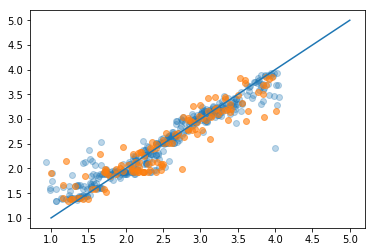

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(r8[[str(i) for i in range(72)]], r8['X'])

regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)
plt.scatter(y_train, regr.predict(X_train), alpha=0.3)
plt.scatter(y_test, regr.predict(X_test).clip(0, 5), alpha=0.6)
plt.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])

In [12]:
math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2))

0.2802083491161152

/home/jonathan/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


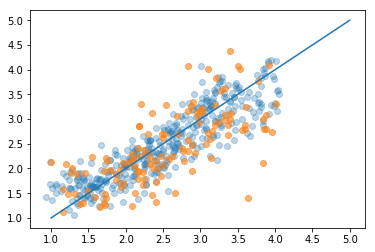

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mlpc = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=100)
mlpc.fit(X_train, y_train)

plt.scatter(y_train, mlpc.predict(X_train), alpha=0.3)
plt.scatter(y_test, mlpc.predict(X_test).clip(0, 5), alpha=0.6)
plt.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])

In [16]:
math.sqrt(np.mean((mlpc.predict(X_test) - y_test) ** 2))

0.5834616448960166

In [22]:
A = (np.abs(regr.predict(X_test) - y_test)/5).tolist()
np.mean(A)

0.16128468201612878

/home/jonathan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


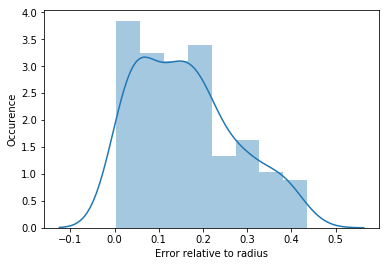

In [21]:
import seaborn as sns
xe = A
ax = sns.distplot(xe);
ax.set_xlabel('Error relative to radius')
ax.set_ylabel('Occurence')
plt.savefig('ring_of_8_error_distribution.png')

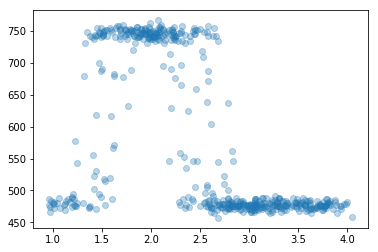

In [39]:
plt.scatter(r8['Y'], r8['39'], alpha=0.3)